In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
stock = yf.download("AAPL", start="2018-01-01", end="2023-01-01")


[*********************100%***********************]  1 of 1 completed


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

In [4]:
stock['MA50'] = stock['Close'].rolling(window=50).mean()
stock['MA200'] = stock['Close'].rolling(window=200).mean()
stock['Daily Return'] = stock['Close'].pct_change()
stock.dropna(inplace=True)


In [42]:
features = stock[['Close', 'MA50', 'MA200', 'Daily Return']]
labels = stock['Close'].shift(-1) 
# features.dropna(inplace=True)
# labels.dropna(inplace=True)


In [43]:
features = features.iloc[:-1]
labels = labels.iloc[:-1]


In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)


In [20]:
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('svr', SVR(kernel='rbf')),
    ('ridge', Ridge())
]


In [22]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

stack_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)


In [23]:
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20],
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'ridge__alpha': [0.1, 1, 10]
}


In [25]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(stack_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\ah006\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [26]:
stack_pred = best_model.predict(X_test)


In [47]:
mae = mean_absolute_error(y_test, stack_pred)
rmse = np.sqrt(root_mean_squared_error(y_test, stack_pred))
print(f"Stacking Model - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Stacking Model - MAE: 0.55, RMSE: 0.76


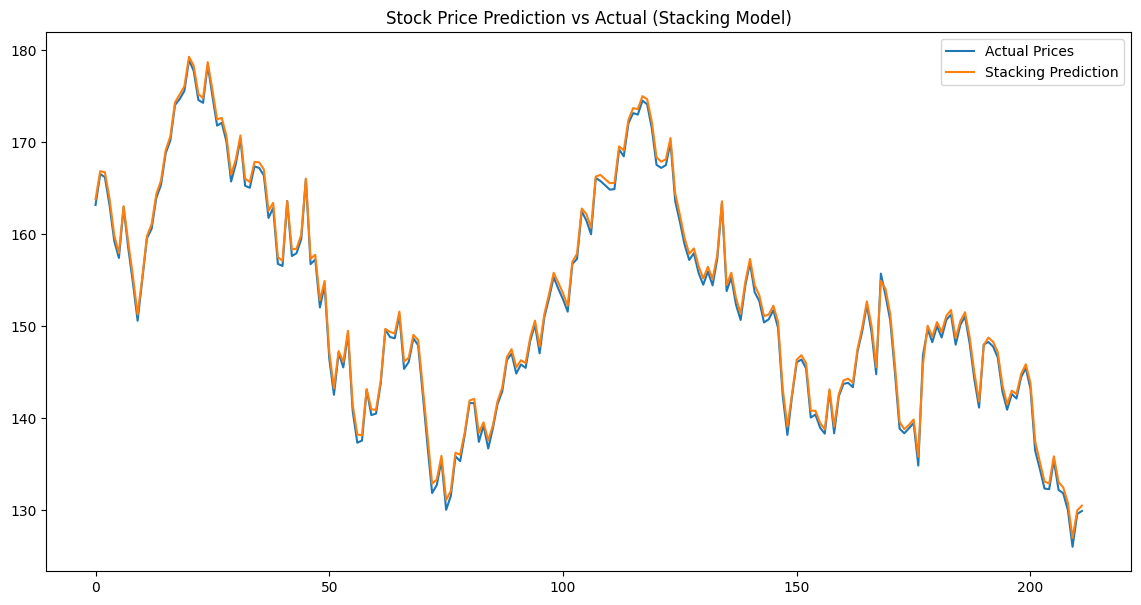

In [48]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(stack_pred, label='Stacking Prediction')
plt.legend()
plt.title("Stock Price Prediction vs Actual (Stacking Model)")
plt.show()
